In [62]:
# install dependencies
!pip install cvxpy tqdm mosek

You should consider upgrading via the '/home/bachir/Dev/sagemath/SageMath/local/bin/python3 -m pip install --upgrade pip' command.


In [57]:
max_deg = 2 # or 4
num_pieces = 3 # number of segments (i.e., linear pieces) in the trajectory
num_iterations = 3 # number of iterations 

# weight of the term in the objective function 
# responsible for minimizign the length
# A high value will push the trajectory to be a straight line going from a to b
weight_length_segment = .5

reg_magnitude = .05  # ridge regularization coefficients
solver = 'MOSEK'  # MOSEK, CVXOPT, etc.
seed = 10
plot_solution_at_every_iteration = True

######################
# problem data
######################

a = [-.5, -.9] # starting point
b = [.7, .4] # end point
M = 1.5 # half lengths of the box where the trajectory lives


# Some obstacle setups to try

# A big disk in the middle
obstacles_as_str = ['x1**2 + x2**2 - .5**2']



# A big disk moving from right to left 
obstacles_as_str = ['(x1-.5+t/5)**2 + x2**2 - .5**2']



# A maze of disks
# obstacles_as_str =  [
#     f"(x1+{-c1})**2 + (x2+{-c2})**2 - .4**2" for c1,c2 in [
#         (-.3,-.3), (-.3,.1), (-.3,.6),
#         (0, -.3),  (0.1, -.3), (0.4, -.3)
#     ]
# ]


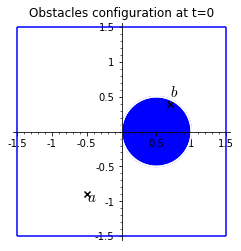


Problem has 54 variables, 37 linear equations, and 45 positive semidefinite matrices


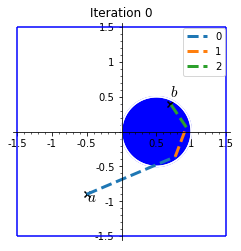

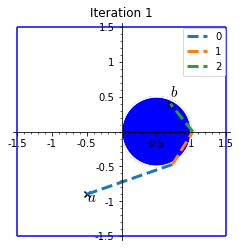

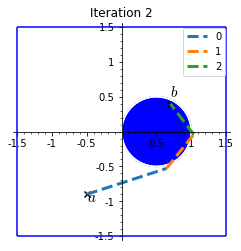

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import helper_functions
from importlib import reload
from tqdm.notebook import trange
reload(helper_functions)

%matplotlib inline
np.random.seed(seed)

###############################
# Plot obstacles configuration
###############################
P = QQ['t, x1, x2, u1, u2, v1, v2']
t, x1, x2, u1, u2, v1, v2 = P.gens()
obstacle_equations = list(map(eval, obstacles_as_str))
box_inequalities = [
    M - x1, M + x1,
    M - x2, M + x2,
]

obstacle_plot = sum(
    (region_plot([SR(gi.subs(t=0)) <= 0 ], (x1, -M, M), (x2, -M, M), alpha=1., )
        for gi in box_inequalities + obstacle_equations),
    plot([])
)

obstacle_plot.matplotlib(figure=plt.gcf())
helper_functions.plot_a_b(a, b)
plt.title("Obstacles configuration at t=0")
plt.show()


# Setup SDP to solve
sdp_data = helper_functions\
        .prepare_sdp_problem(P, M, a, b, obstacle_equations, max_deg, num_pieces)
Lphis, decision_variables, linear_eq, psd_matrices = sdp_data
print(f"Problem has {len(decision_variables)} variables, {len(linear_eq)} linear equations,"
      f" and {len(psd_matrices)} positive semidefinite matrices")


# Replace rank-1 constraint with an iterative minimization scheme
# initialize randomly
random_initialization = np.random.randn(num_pieces, 4)
solution_iteration_k = random_initialization

for k in trange(num_iterations, desc="Iteration"):
    solution_iteration_k = helper_functions.optimize_one_iteration(P, sdp_data,
                       solution_iteration_k, max_deg, weight_length_segment, reg_magnitude, solver)
    if plot_solution_at_every_iteration:
            helper_functions.plot_obstacle_and_trajectory(solution_iteration_k, obstacle_plot, a, b)
            plt.title(f"Iteration {k}")
            plt.show()
            plt.close()
            
optimal_solution = solution_iteration_k

# Examine solution

`optimal_solution[i]` containts a tuple $(u1, u2, v1, v2)$ representing the $i\text{th}$ linear piece

$$x^(i) = (u1+t*u2, v1+t*v2)$$

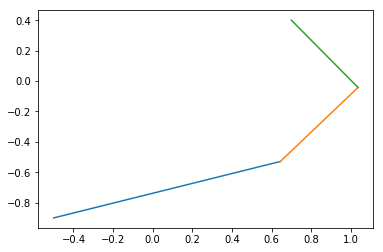

In [59]:
for (u1,u2,v1,v2) in optimal_solution:
    plt.plot([u1,u1+u2], [v1, v1+v2])

# Plot for time varying obstacles

In [60]:
@interact
def plot_at_time(s=(0.88,(0., 1, 0.04))):
    #plt.gcf().clf()
    for (u1,u2,v1,v2) in optimal_solution:
        plt.plot([u1,u1+u2], [v1, v1+v2], 'r--')
    
    current_piece = min(int(s*num_pieces), num_pieces-1)
    u1,u2,v1,v2 = optimal_solution[current_piece]
    t = s*num_pieces-current_piece
    plt.scatter([u1+t*u2], [v1+t*v2])
    
    box_inequalities = [
    M - x1, M + x1,
    M - x2, M + x2,
]

    obstacle_plot = sum(
        (region_plot([SR(gi.subs(t=s)) <= 0 ], (x1, -M, M), (x2, -M, M), alpha=1., )
            for gi in box_inequalities + obstacle_equations),
        plot([])
    )

    obstacle_plot.matplotlib(figure=plt.gcf())
    helper_functions.plot_a_b(a, b)
    plt.title(f"Obstacles configuration at t={s}")
    plt.show()



Interactive function <function plot_at_time at 0x7f5ae39fc268> with 1 widget
  s: FloatSlider(value=0.88, desc…